In [ ]:
"""

Apply SURE CNN technique on striped data to evaluate the performance of the neural network for destriping as the original paper is on denoising

Author: Pun Sukcharoenchaikul
"""

'\n\nApply SURE CNN technique on striped data to evaluate the performance of the neural network for destriping as the original paper is on denoising\n\nAuthor: Pun Sukcharoenchaikul\n'

In this notebook, we will test the performance of SURE CNN from this [paper](https://www.google.com/url?q=https://www.researchgate.net/profile/Nguyen-Van-Han/publication/342846315_Hyperspectral_Image_Denoising_Using_SURE-Based_Unsupervised_Convolutional_Neural_Networks/links/5f6475c392851c14bc840b3b/Hyperspectral-Image-Denoising-Using-SURE-Based-Unsupervised-Convolutional-Neural-Networks.pdf&sa=D&source=editors&ust=1653399934301891&usg=AOvVaw25Xdejw6AFYhQOa9WYfB6i). The original paper focuses on denoising with the neural network. We want to test the performance of the neural network when it comes to destriping.

Overview:


*   Apply Stripe to the Data from [apply_stripes](https://https://colab.research.google.com/drive/123_aqllGL5I5yrFuALiHMdTx_WPygg5N?usp=sharing) function
*   Train [SURE CNN](https://https://drive.google.com/file/d/1y1NtX6bvWfkjemMeRqgBENSGvPGuZHBn/view?usp=sharing) with the striped data
* Evaluate the performance using PSNR and MSE of the images



In [ ]:
"""
- Folder in drive
- Then push folder to github
- Need to add cloning github

"""

'\n- Folder in drive\n- Then push folder to github\n- Need to add cloning github\n\n'

In [ ]:
# external
# mount google drive
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!pip install import_ipynb
# external
import import_ipynb

destriping_root = "/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/"
# Add Destriping Folder to get module from apply_stripes notebook
%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions

# stdlib
import os
import sys

# external
import apply_stripes

# file_location = "/content/drive/Shared drives/Space Systems Division/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions"
# sys.path.append(os.path.abspath(file_location))


%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models


# stdlib
import copy
import math
import random

# external
import matplotlib.pyplot as plt  # for plotting purposes
import noise_estimation
import numpy as np
import scipy.io as sio
import tensorflow as tf

folder = "/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master"
%cd $folder
sys.path.append(os.path.abspath(folder))

# stdlib
import os

# external
import matplotlib.pyplot as plt
import scipy.io as sio
from models.skipnet import *
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.common import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 28.9 MB/s 
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions
importing Jupyter notebook from apply_stripes.ipynb
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models
importing Jupyter notebook from noise_estimation.ipynb
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master


**Part 1: Adding Stripes to HSI Images**

In [ ]:
def import_indian_pines_data(to_import=True):
    """
    import Indian Pines dataset from Science Google Drive
    Args:
      import: if True import the dataset from Googel Drive, if false doesn't import
      To change the location of import to github

    Return: print statement of whether the dataset is imported properly or not
    """
    if to_import == True:
        # data get data to add stripe
        #!git clone https://github.com/spacesys-finch/Science #if says error uncomment this line
        # error cloning, so uploaded the data to google drive instead
        data = np.load(
            "/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Datasets/indian_pine_array.npy"
        )

        # changing from callibrated value to radiance
        # radiance_data_np = (data-1000)/500
        radiance_data_np = data.astype(np.float32)
        return radiance_data_np

In [ ]:
# write a function for nomalizing the values in the numpy array


def normalize(numpy_arr_one, numpy_arr_two):
    """
    Normalize the values in numpy_arr_one and numpy_arr_two into values between -1 and 1
    Args:
      numpy_arr_one, numpy_arr_two: numpy arrays of the data to normalize
    Return: numpy_arr_one_norm, numpy_arr_two_norm: two arrays that are normalized
    """

    max_num = max(np.max(numpy_arr_one), np.max(numpy_arr_two))
    divisor = np.ones(numpy_arr_one.shape) * max_num
    numpy_arr_one_norm = np.divide(numpy_arr_one, divisor)
    numpy_arr_two_norm = np.divide(numpy_arr_two, divisor)
    return numpy_arr_one_norm, numpy_arr_two_norm, max_num

In [ ]:
def band_by_band_normalize(numpy_array):
    """
    Normalize the values in numpy_array band by band to between 0 and 1
    Args:
      numpy_array: 3D array of hyperspectral image
    Return:
      numpy_array_norm: normalized numpy array
    """
    bands = numpy_array.shape[2]
    for i in range(bands):
        max_num = np.max(numpy_array[:, :, i])
        numpy_array[:, :, i] = np.divide(numpy_array[:, :, i], max_num)
    return numpy_array

In [ ]:
# reshape data to (1, data.shape[0], data.shape[1], data.shape[2])
def reshape(data):
    """
    Args: 3D Numpy array, Output: Reshaped 4D Numpy array
    Reshape HSI data from 3D to 4D to pass into CNN
    Ex. original data shape (20, 30, 40) will turn into (1, 20, 30, 40)
    """
    data_reshaped = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])
    return data_reshaped

In [ ]:
def create_uniform_datacube(data, band, num_bands):
    """
    Creates a HSI datacube (3D array) with one band copied over to all the bands
    Args:
      data: original HSI data want to be copied
      band: the band that will be copied
      num_bands: number of band that the new datacube will have
    Return:
      datacube: the resulting datacube from copying one band over
    """
    datacube = np.zeros((data.shape[0], data.shape[1], num_bands))
    for i in range(num_bands):
        datacube[:, :, i] = np.copy(data[:, :, band])
    return datacube

In [ ]:
def define_model(striped_data):
    """
    Define the models and the necessary parameters of the model

    Args: None
    Return:
      mymodel: model of the defined properties
      lr: alpha value
      myoptimizer: optimizer of choice
      loss_object: type of loss object
    """
    # Define model
    mymodel = skip(ndown=5, channel=striped_data.shape[-1])
    lr = 0.001
    myoptimizer = tf.keras.optimizers.Adam(lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    return mymodel, lr, myoptimizer, loss_object

In [ ]:
# Calculate gradient
@tf.function
def grad(model, inputs, targets):
    sure = True
    with tf.GradientTape() as tape:
        loss_value, div_value = losshyper(
            model, inputs, targets, sigma=sigmaest, sure=sure
        )
    return loss_value, div_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# function for calculating mean ssim (Structural Similarity Index)
def meanssim(X, Y):
    """
    Calculate the mean SSIM of the two images X and Y

    Args:
    x: first image to compare
    y: second image to compare with

    return
    np.mean(bandssim): mean similarity of the two images x and y
    """
    bandssim = []
    for i in range(X.shape[2]):
        bandssim.append(
            ssim(
                X[:, :, i],
                Y[:, :, i],
                data_range=1.0,
                K1=0.01,
                K2=0.03,
                gaussian_weights=True,
                sigma=1.5,
                use_sample_covariance=False,
            )
        )
    return np.mean(bandssim)

In [ ]:
def train_model(train, model_file_path, striped_data, clean_data, num_epochs):
    """
    This function train the model and save the model

    Args:
      train: if true, train, if false not train
      model_file_path: filepath that the model is saved at
      striped_data: striped_data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])
      clean_data: clean data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      train_loss_results: list of the training loss
      destriped_psnr: list of the psnr between the

    """
    if train == True:
        mymodel, lr, myoptimizer, loss_object = define_model(striped_data)
        sure = True
        # start training
        train_loss_results = []
        train_div_results = []
        destriped_psnr = []
        destriped_ssim = []
        curr_psnr = 0
        sure = True
        # for loop for going through each epoch
        for epoch in range(num_epochs):
            loss_label = "SURE"
            # get gradient for the current model
            loss_value, div_value, grads = grad(mymodel, striped_data, striped_data)
            # apply gradient to the optimizer
            myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
            img_out = mymodel.predict(striped_data)
            # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
            if psnr(clean_data[0], img_out[0]) > curr_psnr:
                print("Saving Model")
                tf.keras.models.save_model(mymodel, model_file_path)
                curr_psnr = psnr(clean_data[0], img_out[0])
            curr_ssim = meanssim(clean_data[0], img_out[0])

            print("This is running epoch %d and Loss %f" % (epoch, loss_value))
            print("PSNR: " + str(curr_psnr))
            print("SSIM: " + str(curr_ssim))
            print(
                "Iteration %05d    Loss %f     PSNR %f    SSIM: "
                % (epoch, loss_value, curr_psnr),
                "\r",
                end="",
            )
            # updating loss, div, ssim
            train_loss_results.append(loss_value)
            train_div_results.append(div_value)
            destriped_psnr.append(curr_psnr)
            destriped_ssim.append(curr_ssim)

        return train_loss_results, destriped_psnr, destriped_ssim

    else:
        print("Does not train")
        return [0], [0]

In [ ]:
def train_model_with_ssim(train, model_file_path, striped_data, clean_data, num_epochs):
    """
    This function train the model and save the model

    Args:
      train: if true, train, if false not train
      model_file_path: filepath that the model is saved at
      striped_data: striped_data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])
      clean_data: clean data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      train_loss_results: list of the training loss
      destriped_psnr: list of the psnr between the

    """
    if train == True:
        mymodel, lr, myoptimizer, loss_object = define_model(striped_data)
        sure = True
        # start training
        train_loss_results = []
        train_div_results = []
        destriped_psnr = []
        destriped_ssim = []
        curr_psnr = 0
        curr_ssim = 0
        sure = True
        # for loop for going through each epoch
        for epoch in range(num_epochs):
            loss_label = "SURE"
            # get gradient for the current model
            loss_value, div_value, grads = grad(mymodel, striped_data, striped_data)
            # apply gradient to the optimizer
            myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
            img_out = mymodel.predict(striped_data)
            # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
            if meanssim(clean_data[0], img_out[0]) > curr_ssim:
                print("Saving Model")
                tf.keras.models.save_model(mymodel, model_file_path)
                curr_ssim = meanssim(clean_data[0], img_out[0])
            curr_psnr = psnr(clean_data[0], img_out[0])

            print("This is running epoch %d and Loss %f" % (epoch, loss_value))
            print("PSNR: " + str(curr_psnr))
            print("SSIM: " + str(curr_ssim))
            print(
                "Iteration %05d    Loss %f     PSNR %f    SSIM: "
                % (epoch, loss_value, curr_psnr),
                "\r",
                end="",
            )
            # updating loss, div, ssim
            train_loss_results.append(loss_value)
            train_div_results.append(div_value)
            destriped_psnr.append(curr_psnr)
            destriped_ssim.append(curr_ssim)

        return train_loss_results, destriped_psnr, destriped_ssim

    else:
        print("Does not train")
        return [0], [0]

In [ ]:
def load_model_and_predict(filepath, striped_data):
    """
    This function load the saved model from the filepath and apply the model to striped_data to get the output

    Args:
      filepath: filepath that the model is saved in, the model should be of type .hdf5
      striped_data: striped_data in the format of numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      bestmodel: the model that is loaded from the filepath
      out_best: the output from passing striped_data into the loaded model
    """
    # set the model to load the trained model
    bestmodel = tf.keras.models.load_model(filepath)
    # pass the noisy image into the model to get the output from the trained model
    out_best = bestmodel.predict(striped_data)
    return bestmodel, out_best

In [ ]:
ip_radiance_data_np = import_indian_pines_data()
ip_radiance_data_np = create_uniform_datacube(ip_radiance_data_np, 100, 50)
ip_striped_data_np = ip_radiance_data_np
ip_radiance_data_np = band_by_band_normalize(ip_radiance_data_np)
ip_striped_data_np = band_by_band_normalize(ip_radiance_data_np)

# ip_radiance_data_np, ip_striped_data_np, factor = normalize(ip_radiance_data_np, ip_radiance_data_np)
# ip_striped_data_np *= 10
num_stripes = []
for i in range(200):
    num_stripes.append(25)
ip_striped_data_np = apply_stripes.add_basic_stripes(ip_radiance_data_np, num_stripes)

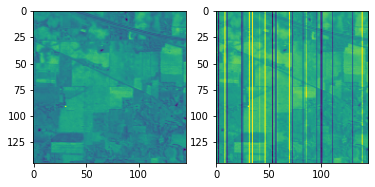

In [ ]:
# plot the striped images
band = 40
plt.subplot(121)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.show()

In [ ]:
def import_txt_file(folder, filename):
    %cd $folder
    sys.path.append(os.path.abspath(folder))
    res = np.loadtxt(filename)
    return res

**Part 2: Training SURE CNN**

Installing Dependencies for SURE CNN

Reshape Image from 3D to 4D to pass into CNN

In [ ]:
# reshape radiance data and striped data
ip_radiance_data = reshape(ip_radiance_data_np)
ip_radiance_data = ip_radiance_data.astype(np.float32)
ip_striped_data = reshape(ip_striped_data_np)
ip_striped_data = ip_striped_data.astype(np.float32)

# define sigmaest, this will need to be looked into it in more depth
sigmaest = noise_estimation.noise_estimate(ip_radiance_data_np)
sigmaest = sigmaest.astype(np.float32)
print(type(sigmaest))
print(ip_radiance_data.shape)
print(ip_radiance_data_np.shape)

(50, 21025)   21025
<class 'numpy.ndarray'>
(1, 145, 145, 50)
(145, 145, 50)


In [ ]:
print("Max Clean Image: " + str(np.max(ip_radiance_data_np)))
print("Min Clean Image: " + str(np.min(ip_radiance_data_np)))
print("Max Striped Image: " + str(np.max(ip_striped_data_np)))
print("Min Striped Image: " + str(np.min(ip_striped_data_np)))

Max Clean Image: 1.0
Min Clean Image: 0.4655515730784548
Max Striped Image: 1.4
Min Striped Image: 0.2327757865392274


In [ ]:
# sigmaest = np.insert(sigmaest, 186, np.ones(14))
# sigmaest = sigmaest/factor

Train and save the best model

In [ ]:
filepath = (
    "./results/best model/Demo/" + "sure" + "indian_pine_create_uniform_array" + ".hdf5"
)

In [ ]:
to_train = True
sure = True
num_epochs = 50
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, ip_striped_data, ip_radiance_data, num_epochs
)

Saving Model
This is running epoch 0 and Loss 0.065087
PSNR: 14.459589632130093
SSIM: 0.6250219857126552


Saving Model
This is running epoch 1 and Loss 0.044182
PSNR: 15.24937169507631
SSIM: 0.6368865645911401


Saving Model
This is running epoch 2 and Loss 0.038577
PSNR: 18.157396828032724
SSIM: 0.662623361363393


Saving Model
This is running epoch 3 and Loss 0.023904
PSNR: 20.03631326256341
SSIM: 0.6769434493668232


Saving Model
This is running epoch 4 and Loss 0.018610
PSNR: 21.691904651879103
SSIM: 0.6790070758523585


Saving Model
This is running epoch 5 and Loss 0.015619
PSNR: 22.509664919802148
SSIM: 0.68185082343014
This is running epoch 6 and Loss 0.014576
PSNR: 22.509664919802148
SSIM: 0.6792953515141236


Saving Model
This is running epoch 7 and Loss 0.014439
PSNR: 24.882516179929635
SSIM: 0.6867972328491757
This is running epoch 8 and Loss 0.012007
PSNR: 24.882516179929635
SSIM: 0.6887089132825577


Saving Model
This is running epoch 9 and Loss 0.012283
PSNR: 25.442661349027944
SSIM: 0.6872038155504496
This is running epoch 10 and Loss 0.011632
PSNR: 25.442661349027944
SSIM: 0.6858316615302654


Saving Model
This is running epoch 11 and Loss 0.011766
PSNR: 25.949895821578775
SSIM: 0.6896161899516818
This is running epoch 12 and Loss 0.011458
PSNR: 25.949895821578775
SSIM: 0.6908397474123505


Saving Model
This is running epoch 13 and Loss 0.011629
PSNR: 26.098604808624675
SSIM: 0.6892101617412385


Saving Model
This is running epoch 14 and Loss 0.011382
PSNR: 26.536583548102026
SSIM: 0.6898108980179822


Saving Model
This is running epoch 15 and Loss 0.011158
PSNR: 26.912170553097017
SSIM: 0.6916527191184801
This is running epoch 16 and Loss 0.010987
PSNR: 26.912170553097017
SSIM: 0.6921604387964141
This is running epoch 17 and Loss 0.011024
PSNR: 26.912170553097017
SSIM: 0.6923196289174133
This is running epoch 18 and Loss 0.010954
PSNR: 26.912170553097017
SSIM: 0.6929693552044968


Saving Model
This is running epoch 19 and Loss 0.010904
PSNR: 26.97373445856213
SSIM: 0.6943488830463962
This is running epoch 20 and Loss 0.010881
PSNR: 26.97373445856213
SSIM: 0.6940533138003115


Saving Model
This is running epoch 21 and Loss 0.010858
PSNR: 27.169256665139518
SSIM: 0.695576296650966


Saving Model
This is running epoch 22 and Loss 0.010790
PSNR: 27.201649849180857
SSIM: 0.696280843693328
This is running epoch 23 and Loss 0.010790
PSNR: 27.201649849180857
SSIM: 0.6951573253455691


Saving Model
This is running epoch 24 and Loss 0.010801
PSNR: 27.410137884509233
SSIM: 0.6963441760066733


Saving Model
This is running epoch 25 and Loss 0.010677
PSNR: 27.412176889444318
SSIM: 0.6979836910651706


Saving Model
This is running epoch 26 and Loss 0.010683
PSNR: 27.550034283950207
SSIM: 0.6983847476582374
This is running epoch 27 and Loss 0.010623
PSNR: 27.550034283950207
SSIM: 0.6981664490728393


Saving Model
This is running epoch 28 and Loss 0.010630
PSNR: 27.608556199863514
SSIM: 0.699152425156791


Saving Model
This is running epoch 29 and Loss 0.010588
PSNR: 27.610377201024722
SSIM: 0.7008337302062061


Saving Model
This is running epoch 30 and Loss 0.010583
PSNR: 27.631654510198402
SSIM: 0.7013593455992531
This is running epoch 31 and Loss 0.010566
PSNR: 27.631654510198402
SSIM: 0.7011986154533595


Saving Model
This is running epoch 32 and Loss 0.010567
PSNR: 27.667876733125713
SSIM: 0.702126710256844


Saving Model
This is running epoch 33 and Loss 0.010540
PSNR: 27.692322704109213
SSIM: 0.7036959285559535


Saving Model
This is running epoch 34 and Loss 0.010530
PSNR: 27.747871431932513
SSIM: 0.7042712339896531
This is running epoch 35 and Loss 0.010498
PSNR: 27.747871431932513
SSIM: 0.7044001693954515


Saving Model
This is running epoch 36 and Loss 0.010486
PSNR: 27.787814518282996
SSIM: 0.7057353851318087
This is running epoch 37 and Loss 0.010456
PSNR: 27.787814518282996
SSIM: 0.7071626479940752


Saving Model
This is running epoch 38 and Loss 0.010459
PSNR: 27.795486222305495
SSIM: 0.7069646801793306


Saving Model
This is running epoch 39 and Loss 0.010430
PSNR: 27.830805400649098
SSIM: 0.7079225333490061
This is running epoch 40 and Loss 0.010409
PSNR: 27.830805400649098
SSIM: 0.7097851566175567


Saving Model
This is running epoch 41 and Loss 0.010411
PSNR: 27.84834615366772
SSIM: 0.7093746526901857


Saving Model
This is running epoch 42 and Loss 0.010390
PSNR: 27.905898300597507
SSIM: 0.710765918632922
This is running epoch 43 and Loss 0.010364
PSNR: 27.905898300597507
SSIM: 0.71231791525215
This is running epoch 44 and Loss 0.010363
PSNR: 27.905898300597507
SSIM: 0.7123453263420798


Saving Model
This is running epoch 45 and Loss 0.010352
PSNR: 27.98355915160503
SSIM: 0.7145158830277392


Saving Model
This is running epoch 46 and Loss 0.010321
PSNR: 28.023985079209254
SSIM: 0.7154165200467587


Saving Model
This is running epoch 47 and Loss 0.010295
PSNR: 28.044878327398173
SSIM: 0.7170738697597612
This is running epoch 48 and Loss 0.010280
PSNR: 28.044878327398173
SSIM: 0.7185601593431612
This is running epoch 49 and Loss 0.010276
PSNR: 28.044878327398173
SSIM: 0.7180710146611855


In [ ]:
PUbestmodel, out_best = load_model_and_predict(filepath, ip_striped_data)

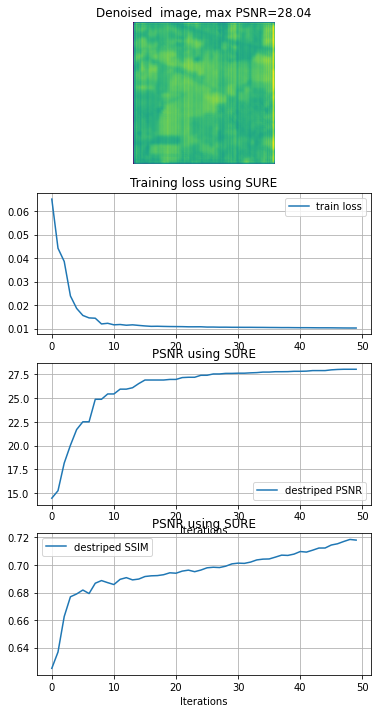

In [ ]:
# show the output image
fig1, (ax, ax1, ax2, ax3) = plt.subplots(4, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, 42], 0, 1))
ax.set_title("Denoised  image, max PSNR=" + str(np.round(np.max(destriped_psnr), 2)))
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

# plot PSNR
ax3.plot(destriped_ssim, label="destriped SSIM")
ax3.set_xlabel("Iterations")
ax3.set_title("PSNR using SURE")
ax3.legend()
ax3.grid()

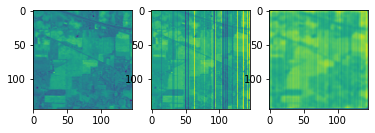

(145, 145, 50)
Original PSNR: 20.44226557106949
Destriped PSNR: 28.044878327398173


In [ ]:
# show the images (clean, noisy, output from the trained model)
band = 36
plt.subplot(131)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(132)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()
print(str(ip_radiance_data_np.shape))
print("Original PSNR: " + str(psnr(ip_radiance_data[0], ip_striped_data[0])))
print("Destriped PSNR: " + str(psnr(ip_radiance_data[0], out_best[0])))

Use sigmaest of the striped image instead of clean image

In [ ]:
ip_radiance_data_np = import_indian_pines_data()
ip_striped_data_np = ip_radiance_data_np
ip_radiance_data_np, ip_striped_data_np, factor = normalize(
    ip_radiance_data_np, ip_radiance_data_np
)
num_stripes = []
for i in range(200):
    num_stripes.append(25)
ip_striped_data_np = apply_stripes.add_basic_stripes(ip_radiance_data_np, num_stripes)

# reshape radiance data and striped data
ip_radiance_data = reshape(ip_radiance_data_np)
ip_radiance_data = ip_radiance_data.astype(np.float32)
ip_striped_data = reshape(ip_striped_data_np)
ip_striped_data = ip_striped_data.astype(np.float32)

# define sigmaest, this will need to be looked into it in more depth
sigmaest = noise_estimation.noise_estimate(ip_striped_data_np)

sigmaest = sigmaest.astype(np.float32)
print(type(sigmaest))
print(ip_radiance_data.shape)
print(ip_radiance_data_np.shape)

(200, 21025)   21025
<class 'numpy.ndarray'>
(1, 145, 145, 200)
(145, 145, 200)


In [ ]:
filepath = (
    "./results/best model/Demo/"
    + "sure"
    + "indian_pine_noise_estimate_function_on_striped_image"
    + ".hdf5"
)

In [ ]:
to_train = True
sure = True
num_epochs = 50
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, ip_striped_data, ip_radiance_data, num_epochs
)

Saving Model


This is running epoch 0 and Loss 0.080131
PSNR: 12.044846639988364
SSIM: 0.5612959916390239
This is running epoch 1 and Loss 0.064149
PSNR: 12.044846639988364
SSIM: 0.38966966336815717
Saving Model


This is running epoch 2 and Loss 0.110856
PSNR: 13.063909238790085
SSIM: 0.610950916866079
Saving Model


This is running epoch 3 and Loss 0.051142
PSNR: 13.351803400463913
SSIM: 0.5951550959391928
Saving Model


This is running epoch 4 and Loss 0.047928
PSNR: 14.287847245413012
SSIM: 0.6252361523627645
Saving Model


This is running epoch 5 and Loss 0.038964
PSNR: 15.026994503848917
SSIM: 0.6536532607250778
Saving Model


This is running epoch 6 and Loss 0.033132
PSNR: 16.19245780831801
SSIM: 0.664146598813864
Saving Model


This is running epoch 7 and Loss 0.025732
PSNR: 17.01308407861047
SSIM: 0.6782326368191134
Saving Model


This is running epoch 8 and Loss 0.021628
PSNR: 18.210838540165287
SSIM: 0.6927464163846473
Saving Model


This is running epoch 9 and Loss 0.016844
PSNR: 19.35350404196219
SSIM: 0.6996276283999714
Saving Model


This is running epoch 10 and Loss 0.013339
PSNR: 20.185891871187295
SSIM: 0.7065793514045581
Saving Model


This is running epoch 11 and Loss 0.011307
PSNR: 21.09052494761506
SSIM: 0.719999762059316
Saving Model


This is running epoch 12 and Loss 0.009503
PSNR: 21.79003234489717
SSIM: 0.730285482975903
Saving Model


This is running epoch 13 and Loss 0.008358
PSNR: 22.208358623505717
SSIM: 0.7369698151972035
Saving Model


This is running epoch 14 and Loss 0.007761
PSNR: 22.55440872275082
SSIM: 0.744801529983971
Saving Model


This is running epoch 15 and Loss 0.007316
PSNR: 22.971367178769757
SSIM: 0.7531850128004968
Saving Model


This is running epoch 16 and Loss 0.006817
PSNR: 23.346287956383538
SSIM: 0.7581636599867795
Saving Model


This is running epoch 17 and Loss 0.006402
PSNR: 23.63849956426848
SSIM: 0.7605933855128876
Saving Model


This is running epoch 18 and Loss 0.006080
PSNR: 23.860860984098014
SSIM: 0.7622425803835864
Saving Model


This is running epoch 19 and Loss 0.005855
PSNR: 24.09611101466364
SSIM: 0.7647641119739813
Saving Model


This is running epoch 20 and Loss 0.005607
PSNR: 24.361898426979902
SSIM: 0.7665025389982557
Saving Model


This is running epoch 21 and Loss 0.005373
PSNR: 24.665134249200538
SSIM: 0.7701457972760872
Saving Model


This is running epoch 22 and Loss 0.005113
PSNR: 24.834392770332407
SSIM: 0.7724298079637885
Saving Model


This is running epoch 23 and Loss 0.004977
PSNR: 25.009155142636807
SSIM: 0.772548564565507
Saving Model


This is running epoch 24 and Loss 0.004859
PSNR: 25.244084124104937
SSIM: 0.7767724363823697
Saving Model


This is running epoch 25 and Loss 0.004689
PSNR: 25.46764302742193
SSIM: 0.7778682872416457
Saving Model


This is running epoch 26 and Loss 0.004546
PSNR: 25.663450402422132
SSIM: 0.7789367616705835
Saving Model


This is running epoch 27 and Loss 0.004426
PSNR: 25.779536792353245
SSIM: 0.7801913326420714
This is running epoch 28 and Loss 0.004348
PSNR: 25.779536792353245
SSIM: 0.7774789680270666
This is running epoch 29 and Loss 0.004379
PSNR: 25.779536792353245
SSIM: 0.7796806455622298
Saving Model


This is running epoch 30 and Loss 0.004435
PSNR: 26.11435873665883
SSIM: 0.7796277712124858
Saving Model


This is running epoch 31 and Loss 0.004169
PSNR: 26.343832101768
SSIM: 0.7816137175284268
This is running epoch 32 and Loss 0.004048
PSNR: 26.343832101768
SSIM: 0.7829194481742957
Saving Model


This is running epoch 33 and Loss 0.004121
PSNR: 26.558620747639296
SSIM: 0.7829632536373231
Saving Model


This is running epoch 34 and Loss 0.003937
PSNR: 26.603334559976048
SSIM: 0.7825749736882343
This is running epoch 35 and Loss 0.003904
PSNR: 26.603334559976048
SSIM: 0.7840669159531454
Saving Model


This is running epoch 36 and Loss 0.003922
PSNR: 26.77247591684525
SSIM: 0.7830290439085088
Saving Model


This is running epoch 37 and Loss 0.003819
PSNR: 27.04901513299447
SSIM: 0.7855303829700935
This is running epoch 38 and Loss 0.003682
PSNR: 27.04901513299447
SSIM: 0.7861624332460448
Saving Model


This is running epoch 39 and Loss 0.003696
PSNR: 27.14091399836395
SSIM: 0.7856012663733277
Saving Model


This is running epoch 40 and Loss 0.003637
PSNR: 27.29447906296238
SSIM: 0.7871234228555231
Saving Model


This is running epoch 41 and Loss 0.003571
PSNR: 27.33046127149567
SSIM: 0.7882110250014478
Saving Model


This is running epoch 42 and Loss 0.003553
PSNR: 27.42959184027725
SSIM: 0.7883743729403938
Saving Model


This is running epoch 43 and Loss 0.003512
PSNR: 27.517276395690764
SSIM: 0.7902370430404855
Saving Model


This is running epoch 44 and Loss 0.003469
PSNR: 27.648107323833422
SSIM: 0.791273999374814
Saving Model


This is running epoch 45 and Loss 0.003418
PSNR: 27.66854129399246
SSIM: 0.7913198860693869
Saving Model


This is running epoch 46 and Loss 0.003417
PSNR: 27.683532922986636
SSIM: 0.7926749443639859
Saving Model


This is running epoch 47 and Loss 0.003404
PSNR: 27.82162805743855
SSIM: 0.7928822376557438
Saving Model


This is running epoch 48 and Loss 0.003355
PSNR: 27.901311312630256
SSIM: 0.7937999928960379
Saving Model


This is running epoch 49 and Loss 0.003320
PSNR: 27.96258035166025
SSIM: 0.7944160773310693


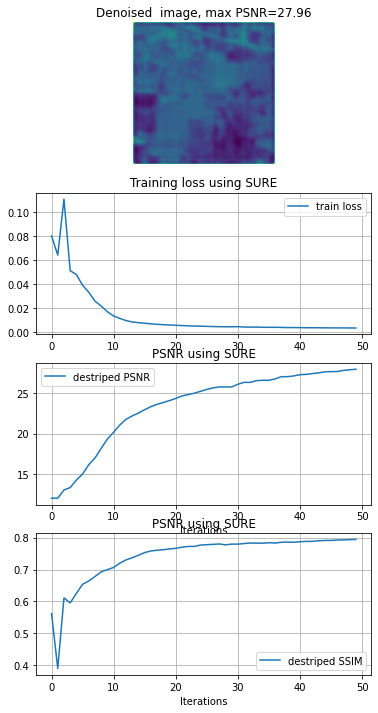

In [ ]:
c

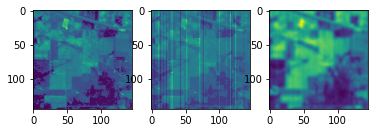

(145, 145, 200)
Original PSNR: 27.61556668107842
Destriped PSNR: 30.841563955212514


In [ ]:
# show the images (clean, noisy, output from the trained model)
band = 12
plt.subplot(131)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(132)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()
print(str(ip_radiance_data_np.shape))
print("Original PSNR: " + str(psnr(ip_radiance_data[0], ip_striped_data[0])))
print("Destriped PSNR: " + str(psnr(ip_radiance_data[0], out_best[0])))

In [ ]:
filepath = (
    "./results/best model/Demo/"
    + "sure"
    + "indian_pine_with_precalculated_sigmaest_4_realsigma2_150epochs"
    + ".hdf5"
)

Does not train


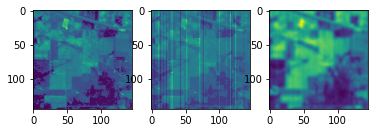

(145, 145, 200)
Original PSNR: 27.61556668107842
Destriped PSNR: 30.841563955212514


In [ ]:
to_train = False
sure = True
train_loss_results, destriped_psnr = train_model(
    to_train, filepath, ip_striped_data, ip_radiance_data, 150
)
PUbestmodel, out_best = load_model_and_predict(filepath, ip_striped_data)
# show the images (clean, noisy, output from the trained model)
band = 12
plt.subplot(131)
plt.imshow(ip_radiance_data_np[:, :, band])
plt.subplot(132)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()
print(str(ip_radiance_data_np.shape))
print("Original PSNR: " + str(psnr(ip_radiance_data[0], ip_striped_data[0])))
print("Destriped PSNR: " + str(psnr(ip_radiance_data[0], out_best[0])))

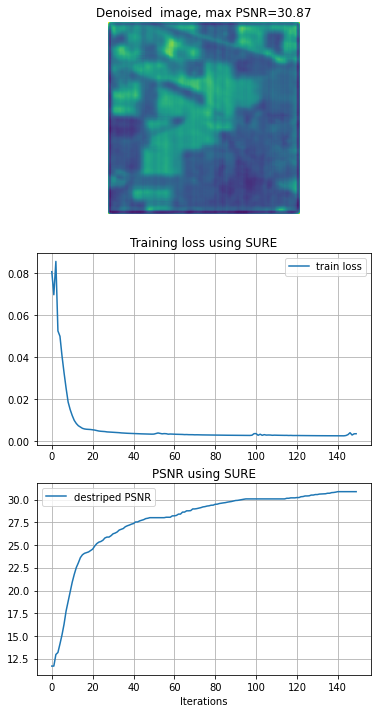

In [ ]:
# show the output image
fig1, (ax, ax1, ax2) = plt.subplots(3, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, 133], 0, 1))
ax.set_title("Denoised  image, max PSNR=" + str(np.round(np.max(destriped_psnr), 2)))
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

NameError: ignored

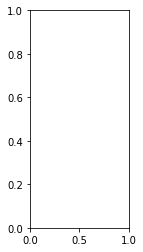

In [ ]:
# show the images (clean, noisy, output from the trained model)
band = 12
plt.subplot(131)
plt.imshow(ip_radiance_data_np[:, :, band])
plt.subplot(132)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, 133], 0, 1))
plt.show()
print(str(ip_radiance_data_np.shape))
print("Original PSNR: " + str(psnr(ip_radiance_data[0], ip_striped_data[0])))
print("Destriped PSNR: " + str(psnr(ip_radiance_data[0], out_best[0])))

Summary: The results we observe is that the SURE CNN cannot perform destriping as well as the loss does not decrease further after 30 and the SSIM is only 0.04. The output image is uniform for each band. This indicates that the CNN does not perform well in destriping images.

We will try with the original data set

(400, 200, 103)
(103, 80000)   80000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


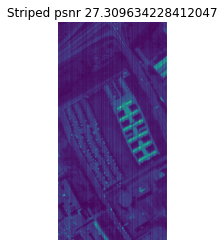

In [ ]:
# load dataset, the one used is from Pavia University
dname = "sigma50eta0PaviaU"
fname = "hsi_data/Demo/" + dname + ".mat"
data = sio.loadmat(fname)

# create clean image numpy array of type float
img_clean_np = data["image"].astype(np.float32)
# get the shape of the dataset (400, 200, 103)
print(img_clean_np.shape)

# create noisy image numpy array of type float
img_striped_np = data["image"].astype(np.float32)

img_clean_np, img_striped_np, factor = normalize(img_clean_np, img_striped_np)

# add stripe using add_basic_stripes function
img_striped_np = apply_stripes.add_basic_stripes(img_striped_np).astype(np.float32)
# sigmaest = data["sigma2"].astype(np.float32) #estimated sigma by Wavelet (sigma2) or HySime (sigma1)
sigmaest = noise_estimation.noise_estimate(img_striped_np)
sigmaest = sigmaest.astype(np.float32)
# sigma=data['noiselev'].astype(np.float32) #True sigma (but unknow in practice)

# show the band 4
plt.imshow(np.clip(img_striped_np[:, :, 4], 0, 1))
# plt.imshow(img_clean_crop[:,:,showband])
plt.title("Striped psnr " + str(psnr(img_clean_np, img_striped_np)))
plt.axis("off")
plt.show()

# reshape the images to (1, 400, 200, 103)
img_striped = img_striped_np.reshape(
    1, img_striped_np.shape[0], img_striped_np.shape[1], img_striped_np.shape[2]
)
img_clean = img_clean_np.reshape(
    1, img_clean_np.shape[0], img_clean_np.shape[1], img_clean_np.shape[2]
)

<class 'numpy.float32'>


In [ ]:
filepath = (
    "./results/best model/Demo/"
    + "sure"
    + "PaviaU2_normalized_ian_noise_estimate"
    + ".hdf5"
)
to_train = False  # Train the model if to_train is true
sure = True
num_epochs = 100
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, img_striped, img_clean, num_epochs
)

Saving Model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


This is running epoch 0 and Loss 0.117653
PSNR: 10.128795214725375
SSIM: 0.23507857684723196
Saving Model


This is running epoch 1 and Loss 0.098843
PSNR: 11.16621639385536
SSIM: 0.22402437210274234
Saving Model


This is running epoch 2 and Loss 0.078216
PSNR: 12.99610890139795
SSIM: 0.23558478432430605
Saving Model


This is running epoch 3 and Loss 0.051965
PSNR: 13.687102399657778
SSIM: 0.23912833554541774
Saving Model


This is running epoch 4 and Loss 0.044590
PSNR: 14.932905420639834
SSIM: 0.2358656522034248
Saving Model


This is running epoch 5 and Loss 0.033903
PSNR: 15.493207021699341
SSIM: 0.23237727091527527
Saving Model


This is running epoch 6 and Loss 0.030012
PSNR: 15.888874143189355
SSIM: 0.24025636325481187
Saving Model


This is running epoch 7 and Loss 0.027566
PSNR: 16.337385569935687
SSIM: 0.26039190283200675
Saving Model


This is running epoch 8 and Loss 0.025045
PSNR: 16.689920654394616
SSIM: 0.2778616630304805
Saving Model


This is running epoch 9 and Loss 0.023247
PSNR: 16.99873794492413
SSIM: 0.29934921322553454
Saving Model


This is running epoch 10 and Loss 0.021792
PSNR: 17.291653889351444
SSIM: 0.3237313017927
Saving Model


This is running epoch 11 and Loss 0.020489
PSNR: 17.669419095088173
SSIM: 0.3451911387711823
Saving Model


This is running epoch 12 and Loss 0.018943
PSNR: 17.979447136105044
SSIM: 0.38472613417794893
Saving Model


This is running epoch 13 and Loss 0.017753
PSNR: 18.303875553609192
SSIM: 0.40078682707668983
This is running epoch 14 and Loss 0.016605
PSNR: 18.303875553609192
SSIM: 0.4615994236223323
This is running epoch 15 and Loss 0.016859
PSNR: 18.303875553609192
SSIM: 0.23237576750033942
This is running epoch 16 and Loss 0.025161
PSNR: 18.303875553609192
SSIM: 0.3292614590123735
Saving Model


This is running epoch 17 and Loss 0.019988
PSNR: 18.490009749261205
SSIM: 0.441691227039959
This is running epoch 18 and Loss 0.015972
PSNR: 18.490009749261205
SSIM: 0.44818542404583095
Saving Model


This is running epoch 19 and Loss 0.018230
PSNR: 18.887451624797023
SSIM: 0.44204182618659055
This is running epoch 20 and Loss 0.014725
PSNR: 18.887451624797023
SSIM: 0.39150667573832926
Saving Model


This is running epoch 21 and Loss 0.016393
PSNR: 19.10624897621364
SSIM: 0.4523309406836398
This is running epoch 22 and Loss 0.014072
PSNR: 19.10624897621364
SSIM: 0.5010416733268888
Saving Model


This is running epoch 23 and Loss 0.014512
PSNR: 19.402599272393278
SSIM: 0.5138392699642444
Saving Model


This is running epoch 24 and Loss 0.013246
PSNR: 19.407827823512708
SSIM: 0.4776056711619608
Saving Model


This is running epoch 25 and Loss 0.013253
PSNR: 19.694148588158985
SSIM: 0.501146123377796
Saving Model


This is running epoch 26 and Loss 0.012526
PSNR: 19.999474633557174
SSIM: 0.5597373107826591
Saving Model


This is running epoch 27 and Loss 0.011786
PSNR: 20.2651021616226
SSIM: 0.5763440477514903
Saving Model


This is running epoch 28 and Loss 0.011196
PSNR: 20.351375912888958
SSIM: 0.5604660531320168
Saving Model


This is running epoch 29 and Loss 0.011027
PSNR: 20.908738902792983
SSIM: 0.5927242252786932
This is running epoch 30 and Loss 0.009911
PSNR: 20.908738902792983
SSIM: 0.6050563337446716
Saving Model


This is running epoch 31 and Loss 0.010558
PSNR: 21.38179437438974
SSIM: 0.6168008766895964
This is running epoch 32 and Loss 0.009069
PSNR: 21.38179437438974
SSIM: 0.6170628718915467
Saving Model


This is running epoch 33 and Loss 0.009157
PSNR: 21.52450517358071
SSIM: 0.6327440657968505
Saving Model


This is running epoch 34 and Loss 0.008829
PSNR: 22.231558782350653
SSIM: 0.648916926628952
This is running epoch 35 and Loss 0.007776
PSNR: 22.231558782350653
SSIM: 0.6404559431260537
Saving Model


This is running epoch 36 and Loss 0.008233
PSNR: 22.64602645295538
SSIM: 0.6638943351698118
Saving Model


This is running epoch 37 and Loss 0.007235
PSNR: 22.75743788744216
SSIM: 0.6681495405200375
This is running epoch 38 and Loss 0.007100
PSNR: 22.75743788744216
SSIM: 0.6619466891606025
Saving Model


This is running epoch 39 and Loss 0.007248
PSNR: 23.579841368984766
SSIM: 0.6810217342649723
This is running epoch 40 and Loss 0.006196
PSNR: 23.579841368984766
SSIM: 0.6802331039536982
This is running epoch 41 and Loss 0.006547
PSNR: 23.579841368984766
SSIM: 0.6586268050854576
Saving Model


This is running epoch 42 and Loss 0.007443
PSNR: 24.049915234710628
SSIM: 0.6903016806676013
This is running epoch 43 and Loss 0.005745
PSNR: 24.049915234710628
SSIM: 0.6829869890293445
This is running epoch 44 and Loss 0.006645
PSNR: 24.049915234710628
SSIM: 0.6996883246602899
Saving Model


This is running epoch 45 and Loss 0.005852
PSNR: 24.053885214111066
SSIM: 0.7033041319833357
This is running epoch 46 and Loss 0.005736
PSNR: 24.053885214111066
SSIM: 0.6991874497672954
This is running epoch 47 and Loss 0.006138
PSNR: 24.053885214111066
SSIM: 0.6980250747875397
Saving Model


This is running epoch 48 and Loss 0.005867
PSNR: 24.68845791481794
SSIM: 0.711305889160318
This is running epoch 49 and Loss 0.005207
PSNR: 24.68845791481794
SSIM: 0.7210235830293483
Saving Model


This is running epoch 50 and Loss 0.005376
PSNR: 25.212673903100715
SSIM: 0.7279725859004674
This is running epoch 51 and Loss 0.004818
PSNR: 25.212673903100715
SSIM: 0.7203412507534614
Saving Model


This is running epoch 52 and Loss 0.005061
PSNR: 25.6123784681005
SSIM: 0.7345566509831032
This is running epoch 53 and Loss 0.004549
PSNR: 25.6123784681005
SSIM: 0.7342236122296424
This is running epoch 54 and Loss 0.005154
PSNR: 25.6123784681005
SSIM: 0.7366749498501873
This is running epoch 55 and Loss 0.004626
PSNR: 25.6123784681005
SSIM: 0.7364259523405092
Saving Model


This is running epoch 56 and Loss 0.004621
PSNR: 25.773897325097387
SSIM: 0.7480469979641089
Saving Model


This is running epoch 57 and Loss 0.004451
PSNR: 26.11357358530022
SSIM: 0.752716486994754
This is running epoch 58 and Loss 0.004248
PSNR: 26.11357358530022
SSIM: 0.7468254199119355
Saving Model


This is running epoch 59 and Loss 0.004422
PSNR: 26.529844290406658
SSIM: 0.7568508942116176
This is running epoch 60 and Loss 0.004023
PSNR: 26.529844290406658
SSIM: 0.7575182217205008
Saving Model


This is running epoch 61 and Loss 0.004231
PSNR: 26.564141306184695
SSIM: 0.7570576806875094
Saving Model


This is running epoch 62 and Loss 0.004010
PSNR: 26.6054048681086
SSIM: 0.7591099973261703
This is running epoch 63 and Loss 0.003990
PSNR: 26.6054048681086
SSIM: 0.7670674329083341
Saving Model


This is running epoch 64 and Loss 0.003998
PSNR: 27.05414601364783
SSIM: 0.7688554829983273
Saving Model


This is running epoch 65 and Loss 0.003775
PSNR: 27.115420674943778
SSIM: 0.7706508987463299
This is running epoch 66 and Loss 0.003748
PSNR: 27.115420674943778
SSIM: 0.7759157988779466
This is running epoch 67 and Loss 0.003859
PSNR: 27.115420674943778
SSIM: 0.7702251270679301
Saving Model


This is running epoch 68 and Loss 0.003782
PSNR: 27.460241495689914
SSIM: 0.7771910561873778
This is running epoch 69 and Loss 0.003597
PSNR: 27.460241495689914
SSIM: 0.780286382708029
This is running epoch 70 and Loss 0.003743
PSNR: 27.460241495689914
SSIM: 0.7756713088649061
Saving Model


This is running epoch 71 and Loss 0.003762
PSNR: 27.655027472156895
SSIM: 0.7849663336716879
This is running epoch 72 and Loss 0.003511
PSNR: 27.655027472156895
SSIM: 0.7878834336198418
This is running epoch 73 and Loss 0.003697
PSNR: 27.655027472156895
SSIM: 0.7812115518065165
Saving Model


This is running epoch 74 and Loss 0.003707
PSNR: 27.812336467204418
SSIM: 0.790998852409316
This is running epoch 75 and Loss 0.003453
PSNR: 27.812336467204418
SSIM: 0.7937356146792058
This is running epoch 76 and Loss 0.003697
PSNR: 27.812336467204418
SSIM: 0.7892535937592176
Saving Model


This is running epoch 77 and Loss 0.003632
PSNR: 27.919393589963025
SSIM: 0.7963210240710932
This is running epoch 78 and Loss 0.003409
PSNR: 27.919393589963025
SSIM: 0.797539752617727
This is running epoch 79 and Loss 0.003663
PSNR: 27.919393589963025
SSIM: 0.7952338355481277
This is running epoch 80 and Loss 0.003477
PSNR: 27.919393589963025
SSIM: 0.7977546233031565
This is running epoch 81 and Loss 0.003414
PSNR: 27.919393589963025
SSIM: 0.8031870628176919
Saving Model


This is running epoch 82 and Loss 0.003552
PSNR: 28.22486156505398
SSIM: 0.8038683751935802
This is running epoch 83 and Loss 0.003299
PSNR: 28.22486156505398
SSIM: 0.8022770191326412
This is running epoch 84 and Loss 0.003414
PSNR: 28.22486156505398
SSIM: 0.8080102718224845
Saving Model


This is running epoch 85 and Loss 0.003349
PSNR: 28.378296251057982
SSIM: 0.8101756075532257
This is running epoch 86 and Loss 0.003247
PSNR: 28.378296251057982
SSIM: 0.8058424147369446
Saving Model


This is running epoch 87 and Loss 0.003346
PSNR: 28.461391333773747
SSIM: 0.8129114584843051
This is running epoch 88 and Loss 0.003220
PSNR: 28.461391333773747
SSIM: 0.8146249882596679
This is running epoch 89 and Loss 0.003242
PSNR: 28.461391333773747
SSIM: 0.8123880228734306
Saving Model


This is running epoch 90 and Loss 0.003265
PSNR: 28.6317078974255
SSIM: 0.8169239212015538
This is running epoch 91 and Loss 0.003160
PSNR: 28.6317078974255
SSIM: 0.8190222869677424
This is running epoch 92 and Loss 0.003209
PSNR: 28.6317078974255
SSIM: 0.8162644342421079
Saving Model


This is running epoch 93 and Loss 0.003232
PSNR: 28.75669270161659
SSIM: 0.8223021978413916
This is running epoch 94 and Loss 0.003122
PSNR: 28.75669270161659
SSIM: 0.8240503820144388
This is running epoch 95 and Loss 0.003137
PSNR: 28.75669270161659
SSIM: 0.821339084620945
Saving Model


This is running epoch 96 and Loss 0.003182
PSNR: 28.807345113484182
SSIM: 0.826553971076696
Saving Model


In [ ]:
# set the model to load the trained model
PUbestmodel, out_best = load_model_and_predict(filepath, img_striped)
# pass the noisy image into the model to get the output from the trained model

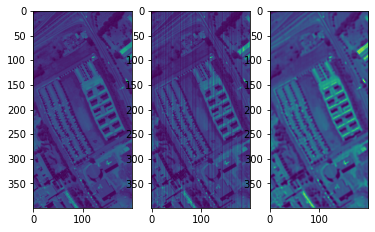

In [ ]:
# show the images (clean, noisy, output from the trained model)
band = 66
plt.subplot(131)
plt.imshow(img_clean_np[:, :, band])
plt.subplot(132)
plt.imshow(np.clip(img_striped_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(out_best[0][:, :, band])
plt.show()

In [ ]:
# print PSNR and Mean SSIM for SURE
print(psnr(img_clean_np, out_best[0]))
print(meanssim(img_clean_np, out_best[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


28.924470022858372
0.8272926700407116


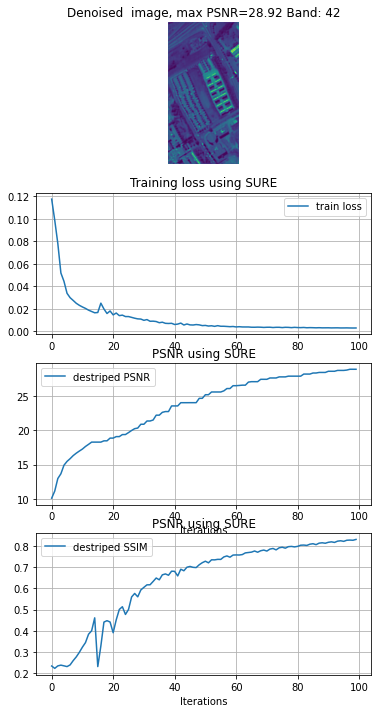

In [ ]:
# show the output image
band = 42
fig1, (ax, ax1, ax2, ax3) = plt.subplots(4, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, band], 0, 1))
ax.set_title(
    "Denoised  image, max PSNR="
    + str(np.round(np.max(destriped_psnr), 2))
    + " Band: "
    + str(band)
)
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

# plot SSIM
ax3.plot(destriped_ssim, label="destriped SSIM")
ax3.set_xlabel("Iterations")
ax3.set_title("PSNR using SURE")
ax3.legend()
ax3.grid()

When we try with the original dataset, visually we noticed that the the neural network does remove stripes. But when we compute PSNR and MSE for evaluating the similarness of the image with stripes and when stripes are removed with the original image, we get a lower PSNR and MSE compared to the striped image. This can be because the destriped image has less original colour compared to the striped images.

In the next section we will generate another stripe image and see whether the current model can destripe the image

In [ ]:
# create noisy image numpy array of type float
img_striped_np2 = data["image"].astype(np.float32)
# add stripe using add_basic_stripes function
img_striped_np2 = apply_stripes.add_basic_stripes(img_striped_np)
sigmaest = data["sigma2"].astype(
    np.float32
)  # estimated sigma by   (sigma2) or HySime (sigma1)

# show the band 57, 27, 17
# showband=[57,27,17]
showband = 57
plt.imshow(np.clip(img_striped_np2[:, :, showband], 0, 1))
# plt.imshow(img_clean_crop[:,:,showband])
plt.title("Striped psnr " + str(psnr(img_clean_np, img_striped_np2)))
plt.axis("off")
plt.show()

# reshape the images to (1, 400, 200, 103)
img_striped2 = img_striped_np2.reshape(
    1, img_striped_np.shape[0], img_striped_np.shape[1], img_striped_np.shape[2]
)
img_clean = img_clean_np.reshape(
    1, img_clean_np.shape[0], img_clean_np.shape[1], img_clean_np.shape[2]
)
print(meanssim(img_clean_np, img_striped_np2))

In [ ]:
# set the model to load the trained model
PUbestmodel = tf.keras.models.load_model(filepath)
# pass the noisy image into the model to get the output from the trained model
out_best = PUbestmodel.predict(img_striped2)

In [ ]:
# show the images (clean, noisy, output from the trained model)
plt.subplot(131)
plt.imshow(img_clean_np[:, :, showband])
plt.subplot(132)
plt.imshow(np.clip(img_striped_np2[:, :, showband], 0, 1))
plt.subplot(133)
plt.imshow(out_best[0][:, :, showband])
plt.show()

In [ ]:
# print PSNR and Mean SSIM for SURE
print(psnr(img_clean_np, out_best[0]))
print(meanssim(img_clean_np, out_best[0]))

For this set, the PSNR and the MSE of the destriped image is slightly better than the striped image. PSNR of the striped image and the original image is 24.1 while PSNR of the destriped image is 24.8. MSE of the striped image and the original image is 0.68 to 0.71.  

# Reshape Sizes
Reshape the Pavia University so that the size matches with the Indian Pine to use Pavia University Model to run on Indian Pine data

Indian Pine Size: 145, 145, 200

Pavia University Size: 400, 200, 103

(1, 145, 145, 103)


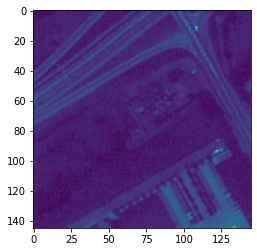

In [ ]:
pavia_clean_resized_np = img_clean_np[:145, :145, :]
pavia_striped_resized_np = apply_stripes.add_basic_stripes(pavia_clean_resized_np)
ip_radiance_data_np, ip_striped_data_np, factor = normalize(
    ip_radiance_data_np, ip_radiance_data_np
)
pavia_clean_resized = reshape(pavia_clean_resized_np)
pavia_striped_resized = reshape(pavia_striped_resized_np)
print(pavia_clean_resized.shape)
plt.imshow(np.clip(pavia_clean_resized_np[:, :, 4], 0, 1))
# plt.imshow(np.clip(pavia_striped_resized_np[:,:,4],0,1))
pavia_striped_resized = pavia_striped_resized.astype(np.float32)
pavia_clean_resized = pavia_clean_resized.astype(np.float32)

In [ ]:
# estimate noise of the cropped image
sigmaest = noise_estimation.noise_estimate(pavia_striped_resized_np)
sigmaest = sigmaest.astype(np.float32)

(103, 21025)   21025


In [ ]:
filepath = (
    "./results/best model/Demo/"
    + "sure"
    + "PaviaUResized_Ian's_noise_estimate"
    + ".hdf5"
)

In [ ]:
filepath = (
    "./results/best model/Demo/"
    + "sure"
    + "PaviaUResized_Ian's_noise_estimate"
    + ".hdf5"
)
to_train = True  # Train the model if to_train is true
sure = True
num_epochs = 50
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, pavia_striped_resized, pavia_clean_resized, num_epochs
)

Saving Model
This is running epoch 0 and Loss 0.127784
PSNR: 9.632535182037145
SSIM: 0.2535362825154467


Saving Model
This is running epoch 1 and Loss 0.110251
PSNR: 11.508695425269373
SSIM: 0.3042878150329889


Saving Model
This is running epoch 2 and Loss 0.071993
PSNR: 13.048622646421997
SSIM: 0.3051899934585311


Saving Model
This is running epoch 3 and Loss 0.050821
PSNR: 15.193790172658993
SSIM: 0.3098335660802222


Saving Model
This is running epoch 4 and Loss 0.031509
PSNR: 15.373540860184251
SSIM: 0.22628270051218793


Saving Model
This is running epoch 5 and Loss 0.030306
PSNR: 16.525274983119584
SSIM: 0.2447702113268736


Saving Model
This is running epoch 6 and Loss 0.023508
PSNR: 17.456814619910478
SSIM: 0.3027523854098904


Saving Model
This is running epoch 7 and Loss 0.019147
PSNR: 17.75731991265482
SSIM: 0.3170673504657952


Saving Model
This is running epoch 8 and Loss 0.017965
PSNR: 18.0065724286978
SSIM: 0.31155715295463626


Saving Model
This is running epoch 9 and Loss 0.017053
PSNR: 18.326302788732256
SSIM: 0.3225127402803446


Saving Model
This is running epoch 10 and Loss 0.015938
PSNR: 18.687201244898745
SSIM: 0.34337439996785946


Saving Model
This is running epoch 11 and Loss 0.014772
PSNR: 18.83192977034177
SSIM: 0.3545780673507079


Saving Model
This is running epoch 12 and Loss 0.014332
PSNR: 19.07016691464854
SSIM: 0.3608192763884598


Saving Model
This is running epoch 13 and Loss 0.013634
PSNR: 19.206391990390937
SSIM: 0.3717503625647706


Saving Model
This is running epoch 14 and Loss 0.013254
PSNR: 19.283785816024405
SSIM: 0.38125210711310104


Saving Model
This is running epoch 15 and Loss 0.013047
PSNR: 19.456430106570995
SSIM: 0.384652965208138


Saving Model
This is running epoch 16 and Loss 0.012585
PSNR: 19.612502243338664
SSIM: 0.39188529207532413
This is running epoch 17 and Loss 0.012180
PSNR: 19.612502243338664
SSIM: 0.39987645342786804


Saving Model
This is running epoch 18 and Loss 0.012256
PSNR: 19.784975375298206
SSIM: 0.40075766198950696


Saving Model
This is running epoch 19 and Loss 0.011748
PSNR: 19.881340404730228
SSIM: 0.40624151294188404


Saving Model
This is running epoch 20 and Loss 0.011515
PSNR: 20.0164443537907
SSIM: 0.4177494013402412


Saving Model
This is running epoch 21 and Loss 0.011205
PSNR: 20.08901012461239
SSIM: 0.4263920199166397


Saving Model
This is running epoch 22 and Loss 0.011039
PSNR: 20.204371408680544
SSIM: 0.42994365102475474


Saving Model
This is running epoch 23 and Loss 0.010773
PSNR: 20.341120649227168
SSIM: 0.43906079891196964


Saving Model
This is running epoch 24 and Loss 0.010480
PSNR: 20.466836483732497
SSIM: 0.45274490315486393


Saving Model
This is running epoch 25 and Loss 0.010230
PSNR: 20.664786821071665
SSIM: 0.4628261736800067


Saving Model
This is running epoch 26 and Loss 0.009830
PSNR: 20.82534967938929
SSIM: 0.475248936099544


Saving Model
This is running epoch 27 and Loss 0.009519
PSNR: 20.930483627668217
SSIM: 0.5019193648586708
This is running epoch 28 and Loss 0.009340
PSNR: 20.930483627668217
SSIM: 0.4020278828479834
This is running epoch 29 and Loss 0.012151
PSNR: 20.930483627668217
SSIM: 0.47488872337804144


Saving Model
This is running epoch 30 and Loss 0.011677
PSNR: 21.22988718802178
SSIM: 0.5015670159937944
This is running epoch 31 and Loss 0.008813
PSNR: 21.22988718802178
SSIM: 0.5012388389640181
This is running epoch 32 and Loss 0.009142
PSNR: 21.22988718802178
SSIM: 0.5109721484698805


Saving Model
This is running epoch 33 and Loss 0.009007
PSNR: 21.357283792496247
SSIM: 0.5295642219260219


Saving Model
This is running epoch 34 and Loss 0.008604
PSNR: 21.424630209184997
SSIM: 0.5312797389302019
This is running epoch 35 and Loss 0.008477
PSNR: 21.424630209184997
SSIM: 0.5454646192375902
This is running epoch 36 and Loss 0.009410
PSNR: 21.424630209184997
SSIM: 0.43514473285331695
This is running epoch 37 and Loss 0.011429
PSNR: 21.424630209184997
SSIM: 0.46725346463695877


Saving Model
This is running epoch 38 and Loss 0.010418
PSNR: 21.5128138669537
SSIM: 0.5429251902951325
This is running epoch 39 and Loss 0.008330
PSNR: 21.5128138669537
SSIM: 0.5405963345188748


Saving Model
This is running epoch 40 and Loss 0.009817
PSNR: 21.772640732369876
SSIM: 0.5565019864786337
This is running epoch 41 and Loss 0.007924
PSNR: 21.772640732369876
SSIM: 0.5382726664281712


Saving Model
This is running epoch 42 and Loss 0.008514
PSNR: 22.277471287705346
SSIM: 0.5828881687570092
This is running epoch 43 and Loss 0.007186
PSNR: 22.277471287705346
SSIM: 0.5937155251054121


Saving Model
This is running epoch 44 and Loss 0.007895
PSNR: 22.312398492522398
SSIM: 0.5908226057693051
This is running epoch 45 and Loss 0.007131
PSNR: 22.312398492522398
SSIM: 0.5936248280650542


Saving Model
This is running epoch 46 and Loss 0.007159
PSNR: 22.787321521975628
SSIM: 0.6296378877691375


Saving Model
This is running epoch 47 and Loss 0.006537
PSNR: 23.19774657249633
SSIM: 0.6408505334398011
This is running epoch 48 and Loss 0.006059
PSNR: 23.19774657249633
SSIM: 0.6265870625623814


Saving Model
This is running epoch 49 and Loss 0.006442
PSNR: 23.52416885823643
SSIM: 0.6513671666538243


In [ ]:
print(filepath)
PUbestmodel, out_best = load_model_and_predict(filepath, pavia_striped_resized)

./results/best model/Demo/surePaviaUResized_Ian's_noise_estimate.hdf5


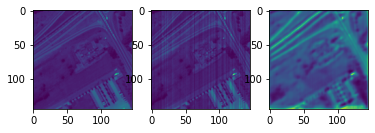

In [ ]:
# show the images (clean, noisy, output from the trained model)
band = 33
plt.subplot(131)
plt.imshow(pavia_clean_resized_np[:, :, band])
plt.subplot(132)
plt.imshow(np.clip(pavia_striped_resized_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()

In [ ]:
resized_ip_striped_data = ip_striped_data[:, :, :, :103]
PUbestmodel, out_best = load_model_and_predict(filepath, resized_ip_striped_data)

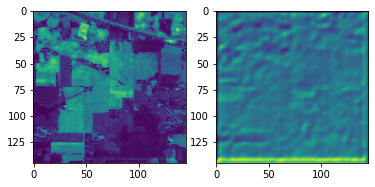

In [ ]:
band = 23
plt.subplot(121)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()

In [ ]:
x = 50
pavia_clean_resized_np = img_clean_np[x : x + 145, x : x + 145, :]
pavia_striped_resized_np = apply_stripes.add_basic_stripes(pavia_clean_resized_np)
ip_radiance_data_np, ip_striped_data_np, factor = normalize(
    ip_radiance_data_np, ip_radiance_data_np
)
pavia_clean_resized = reshape(pavia_clean_resized_np)
pavia_striped_resized = reshape(pavia_striped_resized_np)
print(pavia_clean_resized.shape)
plt.imshow(np.clip(pavia_striped_resized_np[:, :, 4], 0, 1))

In [ ]:
filepath = "./results/best model/Demo/" + "sure" + "PaviaUResized3" + ".hdf5"
to_train = True  # Train the model if to_train is true
sure = True
train_loss_results, destriped_psnr = train_model(
    to_train, filepath, pavia_striped_resized, pavia_clean_resized
)

In [ ]:
print(filepath)
PUbestmodel2, out_best2 = load_model_and_predict(filepath, pavia_striped_resized)

In [ ]:
plt.subplot(121)
plt.imshow(np.clip(pavia_clean_resized_np[:, :, 32], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(out_best2[0][:, :, 32], 0, 1))
plt.show()

In [ ]:
resized_ip_striped_data = ip_striped_data[:, :, :, :103]
PUbestmodel, out_best3 = load_model_and_predict(filepath, resized_ip_striped_data)

In [ ]:
plt.subplot(121)
plt.imshow(np.clip(ip_radiance_data_np[:, :, 74], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(out_best3[0][:, :, 74], 0, 1))
plt.show()
print(psnr(ip_radiance_data_np, out_best[0]))